In [84]:
import pandas as pd
import seaborn as sns
import time
import os
import xgboost
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.neighbors import NearestNeighbors

from src.modelling import hyperparameter_optimization

from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Load Data

In [2]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv", index_col="building_id")
y_train = pd.read_csv("../../data/processed/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

X_train.head(5)

Shape of X_train: (260601, 18)
Shape of y_train: (260601, 1)


,count_families,count_floors_pre_eq,geo_level_1_id,geo_level_2_id,geo_level_3_id,has_secondary_use,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_stone,age,area_percentage,superstructure_quality,foundation_type_r,ground_floor_type_f,ground_floor_type_v,land_surface_condition_t,other_floor_type_q,position_s,roof_type_n
building_id,,,,,,,,,,,,,,,,,,
802906,0.111111,0.125,0.200000,0.341275,0.970637,0.0,0.0,1.0,0.121343,0.247589,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
28830,0.111111,0.125,0.266667,0.630694,0.223761,0.0,0.0,1.0,0.040448,0.346625,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
94947,0.111111,0.125,0.700000,0.254380,0.714013,0.0,0.0,1.0,0.040448,0.198071,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
590882,0.111111,0.125,0.733333,0.292922,0.850959,0.0,0.0,1.0,0.040448,0.247589,0.5,1.0,1.0,0.0,1.0,0.0,1.0,1.0
201944,0.111111,0.250,0.366667,0.091801,0.118405,0.0,0.0,0.0,0.121343,0.346625,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [3]:
# Take subsample for better runtime
X_train = X_train.iloc[:100000]
y_train = y_train.iloc[:100000]

# Get validation set to test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.2)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (80000, 18)
Shape of y_train: (80000, 1)


In [88]:
if not os.path.exists("results"):
    print("Result dir does not exist. Create one.")
    os.makedirs("results")

In [4]:
def save_dataframe(df, prefix, dir="./results/"):
    path = f"{dir}results_of_{prefix}_{datetime.datetime.now()}.csv"
    df.to_csv(path)
    print("DataFrame saved to: " + path)


def get_prediction_score(model, X_val, y_val):
    # Predict on unseen
    y_pred = pd.DataFrame(model.predict(X_val))

    # Since XGBoost predicts [0, 1, 2] classes, we have to transform it to original class labels
    if isinstance(model, xgboost.XGBClassifier):
        print("XGBoost model was used. Renaming predictions ...")
        y_pred = y_pred.replace({0: 1, 1: 2, 2: 3})

    acc = accuracy_score(y_true=y_val, y_pred=y_pred)
    mcc = matthews_corrcoef(y_true=y_val, y_pred=y_pred)
    print(f"ACC on validation set: {acc:.4f}")
    print(f"MCC on validation set: {mcc:.4f}")

    return acc, mcc

def plot_target_distribution(y_train: pd.DataFrame, title:str = "Target Distribution") -> None:
    """
    Expects single dataframe with only one column to analyse, i.e. target distribution
    :param y_train:
    :return:
    """
    # Get dict of winner with keys and corresponding values for plotting
    y_train_value_counts = y_train.value_counts()

    # Plot settings for winner distribution (barplot and pie chart)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=128)
    fig.suptitle(f"{title} ($n = {sum(y_train_value_counts.values)}$)",
                 size=18)
    g = sns.countplot(data=y_train, x="damage_grade", edgecolor="black", ax=axes[0], palette="Paired")
    g.bar_label(g.containers[0])
    axes[1].pie(x=y_train_value_counts,
                autopct='%1.1f%%',
                wedgeprops={"edgecolor":"black", "alpha": 0.75},
                labels=[int(x[0]) for x in y_train_value_counts.keys()],
                explode = np.full(shape=(len(y_train_value_counts.keys())), fill_value=0.05),
                colors=["#1f78b4", "#b2df8a", "#a6cee3"])
    fig.tight_layout()
    plt.show()

# Base: Target Distribution

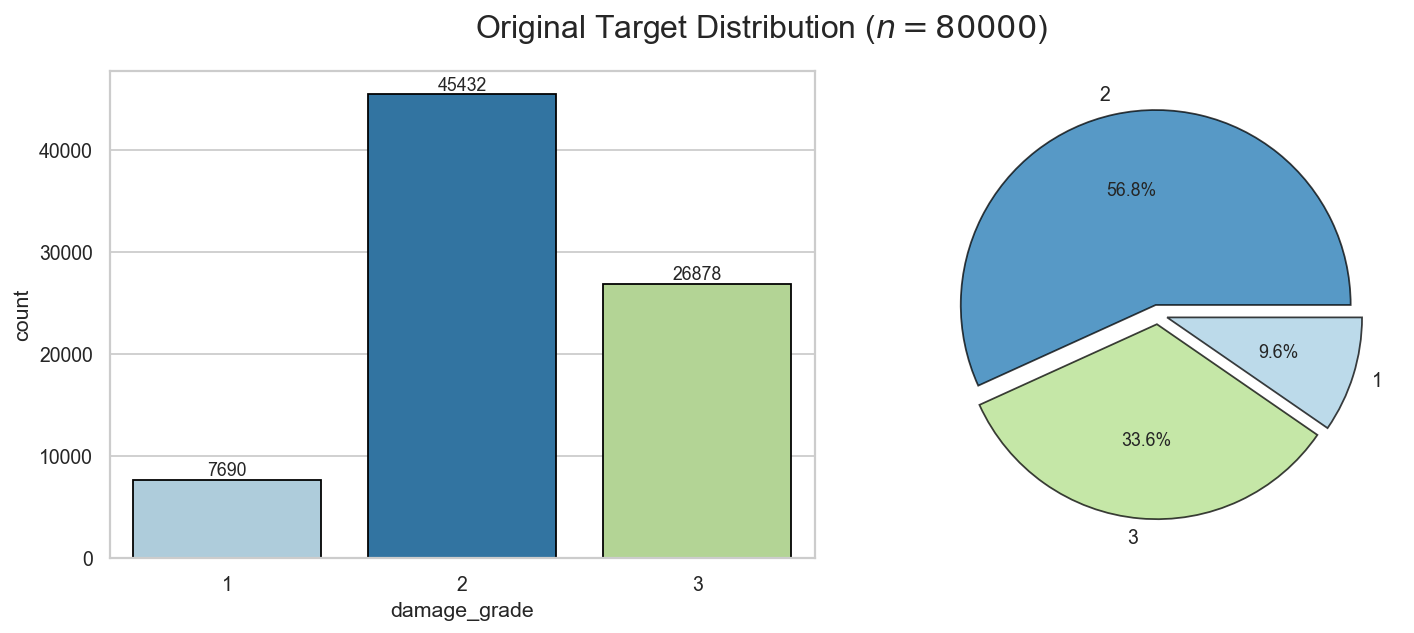

In [5]:
plot_target_distribution(y_train, title="Original Target Distribution")

Before applying all sort of Undersampling and oversampling strategy, we use RandomUnderSampler as the first step (for all samplers) so that we have exactly the same number of class 2 objects than class 3 objects.

In [6]:
val_count = y_train.value_counts()
n_one = val_count.get(1)
n_two = val_count.get(2)
n_three = val_count.get(3)

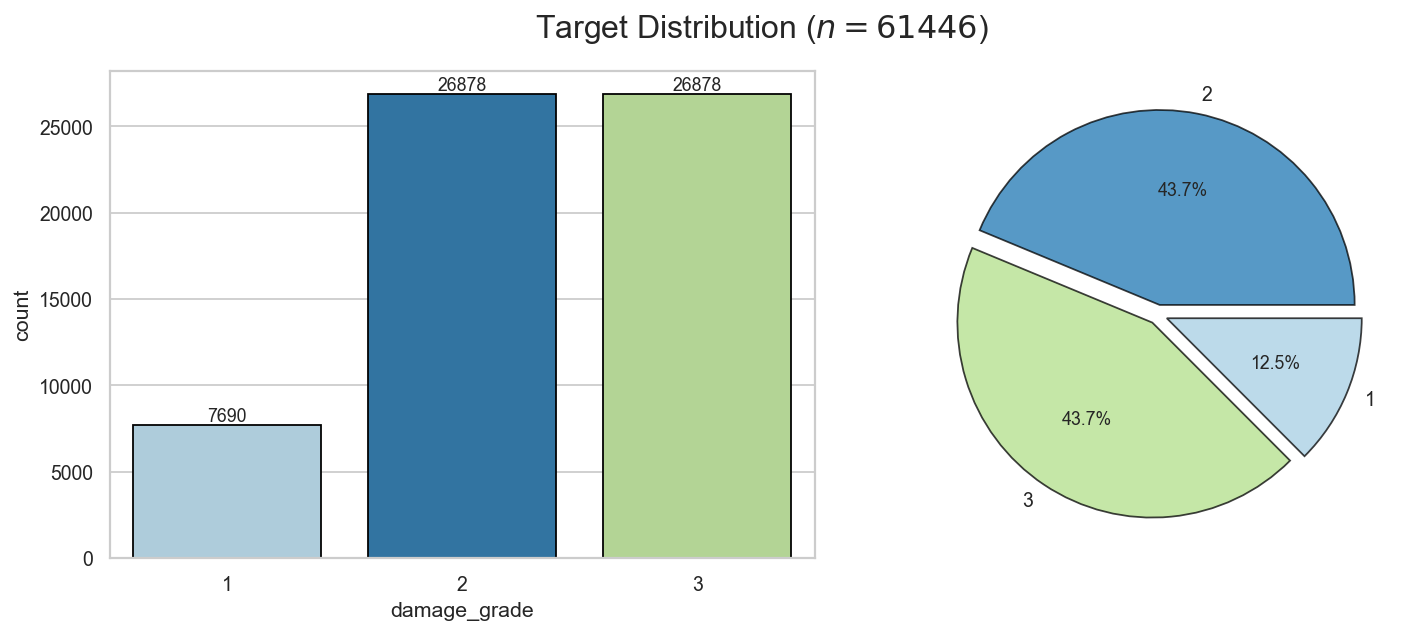

In [7]:
RUS = RandomUnderSampler(random_state=42, sampling_strategy={1: n_one, 2: n_three, 3: n_three})
X_train_rus, y_train_rus = RUS.fit_resample(X_train, y_train)
plot_target_distribution(y_train_rus)

# Experiment: Try different Resampling Methods

In [8]:
# Define sampler here:
mask=[False,False,True,True,True,True,True,True,False,False,True,True,True,True,True,True,True,True]
#smote = SMOTE(random_state=42, k_neighbors=7)
smotenc = SMOTENC(categorical_features=mask, random_state=42, k_neighbors=NearestNeighbors(n_neighbors=10, n_jobs=-1))
kmeanssmote = KMeansSMOTE(random_state=42, k_neighbors=NearestNeighbors(n_neighbors=5, n_jobs=-1))
adasyn = ADASYN(random_state=42, n_neighbors=NearestNeighbors(n_neighbors=10, n_jobs=-1))
svmsmote = SVMSMOTE(random_state=42, k_neighbors=NearestNeighbors(n_neighbors=10, n_jobs=-1),
                    m_neighbors=NearestNeighbors(n_neighbors=20, n_jobs=-1))

# Append to list to iterrate over
samplers = ["base", smotenc, kmeanssmote, adasyn, svmsmote]

def fit_data_using_sampler(samplers=samplers, X_train=X_train, y_train=y_train, show_distribution=False):
    """
    Function to fit and collect data using SMOTE samplers and our final estimator.
    :param samplers: List of samplers to use
    :param X_train: Train data to apply sampler on
    :param y_train: Train data labels to apply sampler on
    :param show_distribution: Bool whether to plot target distribution
    :return: cv results and results on hold-out-set
    """
    results_cv = {}
    results_test_set = {}

    # Initial sampler_name if not using any sampler
    sampler_name = "base"
    for sampler in tqdm(samplers):
        start_time = time.time()

        # If sampeler is not base, use sampler e.g. SMOTE
        if(sampler != "base"):
            # Get Name of Sampler for Visualisation
            sampler_name = str(sampler).split('(')[0]
            # Fit and Resample
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)


        # Plot Distribution
        if show_distribution:
            plot_target_distribution(y_train, title=f"Target Distribution '{sampler_name}'")

        print(f"Using '{sampler_name}':")
        # Get CV Results and model
        if(sampler != "base"):
            model, cv_results = hyperparameter_optimization(model="XGBoost",
                                                train_data=X_train_resampled,
                                                train_labels=y_train_resampled,
                                                scoring=["accuracy", "matthews_corrcoef"])
        else:
            model, cv_results = hyperparameter_optimization(model="XGBoost",
                                                train_data=X_train,
                                                train_labels=y_train,
                                                scoring=["accuracy", "matthews_corrcoef"])
        # Get Score on Test Set
        acc, mcc = get_prediction_score(model, X_val, y_val)
        run_time = np.round((time.time() - start_time), 2)
        print(f"Sampler {sampler_name} took {run_time} s")
        print(80 * "_")

        # Build DataFrame for comparison: CV
        results_cv[f"{sampler_name} ACC"] = cv_results.get("test_accuracy")
        results_cv[f"{sampler_name} MCC"] = cv_results.get("test_matthews_corrcoef")
        # Build DataFrame for comparison: Test Set
        results_test_set[f"{sampler_name}"] = [acc, mcc, run_time]


    results_cv = pd.DataFrame(results_cv, index=[f"{k+1}-fold" for k in np.arange(0, 5)])
    results_test_set = pd.DataFrame(results_test_set, index=["ACC", "MCC", "time"])
    return results_cv, results_test_set

# Apply on normal data
results_cv, results_test_set = fit_data_using_sampler(samplers, X_train, y_train, False)

  0%|          | 0/5 [00:00<?, ?it/s]

Using 'base':
Fitting XGBoost ...

CV Training ACC: 0.9829 +/- 0.0006 
CV Test ACC: 0.7166 +/- 0.0023

CV Training MCC: 0.9692 +/- 0.001 
CV Test MCC: 0.4714 +/- 0.0049



 20%|██        | 1/5 [04:49<19:17, 289.25s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.7272
MCC on validation set: 0.4917
Sampler base took 289.25 s
________________________________________________________________________________
Using 'SMOTENC':
Fitting XGBoost ...

CV Training ACC: 0.9887 +/- 0.0019 
CV Test ACC: 0.8159 +/- 0.0778

CV Training MCC: 0.983 +/- 0.0028 
CV Test MCC: 0.7332 +/- 0.1084



 40%|████      | 2/5 [17:47<28:51, 577.07s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.7163
MCC on validation set: 0.4795
Sampler SMOTENC took 778.55 s
________________________________________________________________________________
Using 'KMeansSMOTE':
Fitting XGBoost ...

CV Training ACC: 0.9887 +/- 0.0027 
CV Test ACC: 0.8015 +/- 0.135

CV Training MCC: 0.9831 +/- 0.004 
CV Test MCC: 0.7215 +/- 0.1791



 60%|██████    | 3/5 [26:12<18:08, 544.22s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.7199
MCC on validation set: 0.4805
Sampler KMeansSMOTE took 505.11 s
________________________________________________________________________________
Using 'ADASYN':
Fitting XGBoost ...

CV Training ACC: 0.9886 +/- 0.0022 
CV Test ACC: 0.7671 +/- 0.0977

CV Training MCC: 0.9829 +/- 0.0033 
CV Test MCC: 0.6674 +/- 0.1249



 80%|████████  | 4/5 [34:45<08:51, 531.57s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.7205
MCC on validation set: 0.4809
Sampler ADASYN took 512.19 s
________________________________________________________________________________
Using 'SVMSMOTE':
Fitting XGBoost ...

CV Training ACC: 0.9838 +/- 0.003 
CV Test ACC: 0.7753 +/- 0.1001

CV Training MCC: 0.9757 +/- 0.0045 
CV Test MCC: 0.6801 +/- 0.1327



100%|██████████| 5/5 [57:55<00:00, 695.10s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.7238
MCC on validation set: 0.4882
Sampler SVMSMOTE took 1390.41 s
________________________________________________________________________________


In [9]:
save_dataframe(results_cv, prefix="cv")
time.sleep(2)
results_cv

DataFrame saved to: ./results/results_of_cv_2023-05-18 14:27:54.263831.csv


,base ACC,base MCC,SMOTENC ACC,SMOTENC MCC,KMeansSMOTE ACC,KMeansSMOTE MCC,ADASYN ACC,ADASYN MCC,SVMSMOTE ACC,SVMSMOTE MCC
1-fold,0.713500,0.464307,0.676926,0.544390,0.549230,0.393781,0.577925,0.429362,0.597799,0.454539
2-fold,0.714875,0.467962,0.809457,0.717661,0.807557,0.718027,0.787117,0.684368,0.780696,0.675150
3-fold,0.720125,0.478820,0.813419,0.723856,0.814233,0.727596,0.786674,0.684542,0.784365,0.680379
4-fold,0.717125,0.472721,0.888807,0.838580,0.917388,0.882988,0.841417,0.768292,0.805752,0.722281
5-fold,0.717313,0.473261,0.890862,0.841330,0.919149,0.885222,0.842451,0.770473,0.907810,0.868074


In [10]:
save_dataframe(results_test_set, prefix="test")
time.sleep(2)
results_test_set

DataFrame saved to: ./results/results_of_test_2023-05-18 14:27:56.350078.csv


,base,SMOTENC,KMeansSMOTE,ADASYN,SVMSMOTE
ACC,0.72720,0.71625,0.719950,0.72045,0.72385
MCC,0.49172,0.47953,0.480499,0.48092,0.48819
time,289.25000,778.55000,505.110000,512.19000,1390.41000


In [11]:
# Apply on data with random undersampled majority class
results_cv_rus, results_test_set_rus = fit_data_using_sampler(samplers, X_train_rus, y_train_rus, False)

  0%|          | 0/5 [00:00<?, ?it/s]

Using 'base':
Fitting XGBoost ...

CV Training ACC: 0.9881 +/- 0.0003 
CV Test ACC: 0.6917 +/- 0.0044

CV Training MCC: 0.9801 +/- 0.0005 
CV Test MCC: 0.483 +/- 0.0077



 20%|██        | 1/5 [03:21<13:24, 201.09s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6984
MCC on validation set: 0.4711
Sampler base took 201.09 s
________________________________________________________________________________
Using 'SMOTENC':
Fitting XGBoost ...

CV Training ACC: 0.9901 +/- 0.0009 
CV Test ACC: 0.7585 +/- 0.0466

CV Training MCC: 0.9851 +/- 0.0013 
CV Test MCC: 0.6402 +/- 0.0667



 40%|████      | 2/5 [08:46<13:43, 274.37s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6934
MCC on validation set: 0.4716
Sampler SMOTENC took 325.66 s
________________________________________________________________________________
Using 'KMeansSMOTE':
Fitting XGBoost ...

CV Training ACC: 0.9901 +/- 0.0006 
CV Test ACC: 0.7497 +/- 0.0776

CV Training MCC: 0.9851 +/- 0.0009 
CV Test MCC: 0.6306 +/- 0.1068



 60%|██████    | 3/5 [13:26<09:14, 277.00s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6949
MCC on validation set: 0.4674
Sampler KMeansSMOTE took 280.14 s
________________________________________________________________________________
Using 'ADASYN':
Fitting XGBoost ...

CV Training ACC: 0.9896 +/- 0.0009 
CV Test ACC: 0.7503 +/- 0.0607

CV Training MCC: 0.9844 +/- 0.0013 
CV Test MCC: 0.6292 +/- 0.0864



 80%|████████  | 4/5 [17:59<04:35, 275.07s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6957
MCC on validation set: 0.4692
Sampler ADASYN took 272.12 s
________________________________________________________________________________
Using 'SVMSMOTE':
Fitting XGBoost ...

CV Training ACC: 0.9884 +/- 0.0007 
CV Test ACC: 0.7567 +/- 0.0617

CV Training MCC: 0.9825 +/- 0.001 
CV Test MCC: 0.6396 +/- 0.0857



100%|██████████| 5/5 [25:53<00:00, 310.69s/it]

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.6961
MCC on validation set: 0.4718
Sampler SVMSMOTE took 474.46 s
________________________________________________________________________________


In [12]:
save_dataframe(results_cv_rus, prefix="cv_rus")
time.sleep(2)
results_cv_rus

DataFrame saved to: ./results/results_of_cv_rus_2023-05-18 14:53:51.884796.csv


,base ACC,base MCC,SMOTENC ACC,SMOTENC MCC,KMeansSMOTE ACC,KMeansSMOTE MCC,ADASYN ACC,ADASYN MCC,SVMSMOTE ACC,SVMSMOTE MCC
1-fold,0.685273,0.471477,0.672103,0.517663,0.601228,0.427944,0.639683,0.473748,0.640107,0.479366
2-fold,0.688583,0.478077,0.746326,0.619978,0.742730,0.615484,0.729524,0.595210,0.746946,0.621206
3-fold,0.695093,0.489132,0.790786,0.687133,0.801265,0.702929,0.793511,0.691663,0.797110,0.696689
4-fold,0.692001,0.483559,0.789607,0.685199,0.800645,0.701804,0.791796,0.688844,0.797234,0.696786
5-fold,0.697453,0.492980,0.793439,0.691122,0.802431,0.704661,0.796812,0.696456,0.801873,0.703948


In [13]:
save_dataframe(results_test_set_rus, prefix="test_rus")
results_test_set_rus

DataFrame saved to: ./results/results_of_test_rus_2023-05-18 14:53:53.915027.csv


,base,SMOTENC,KMeansSMOTE,ADASYN,SVMSMOTE
ACC,0.698400,0.69340,0.694900,0.69575,0.696100
MCC,0.471074,0.47159,0.467441,0.46919,0.471839
time,201.090000,325.66000,280.140000,272.12000,474.460000


In [14]:
results_test_set_rus

,base,SMOTENC,KMeansSMOTE,ADASYN,SVMSMOTE
ACC,0.698400,0.69340,0.694900,0.69575,0.696100
MCC,0.471074,0.47159,0.467441,0.46919,0.471839
time,201.090000,325.66000,280.140000,272.12000,474.460000


# Comparison

Saved figure in results/test_results_of_2023-05-18 15:45:48.027377.png


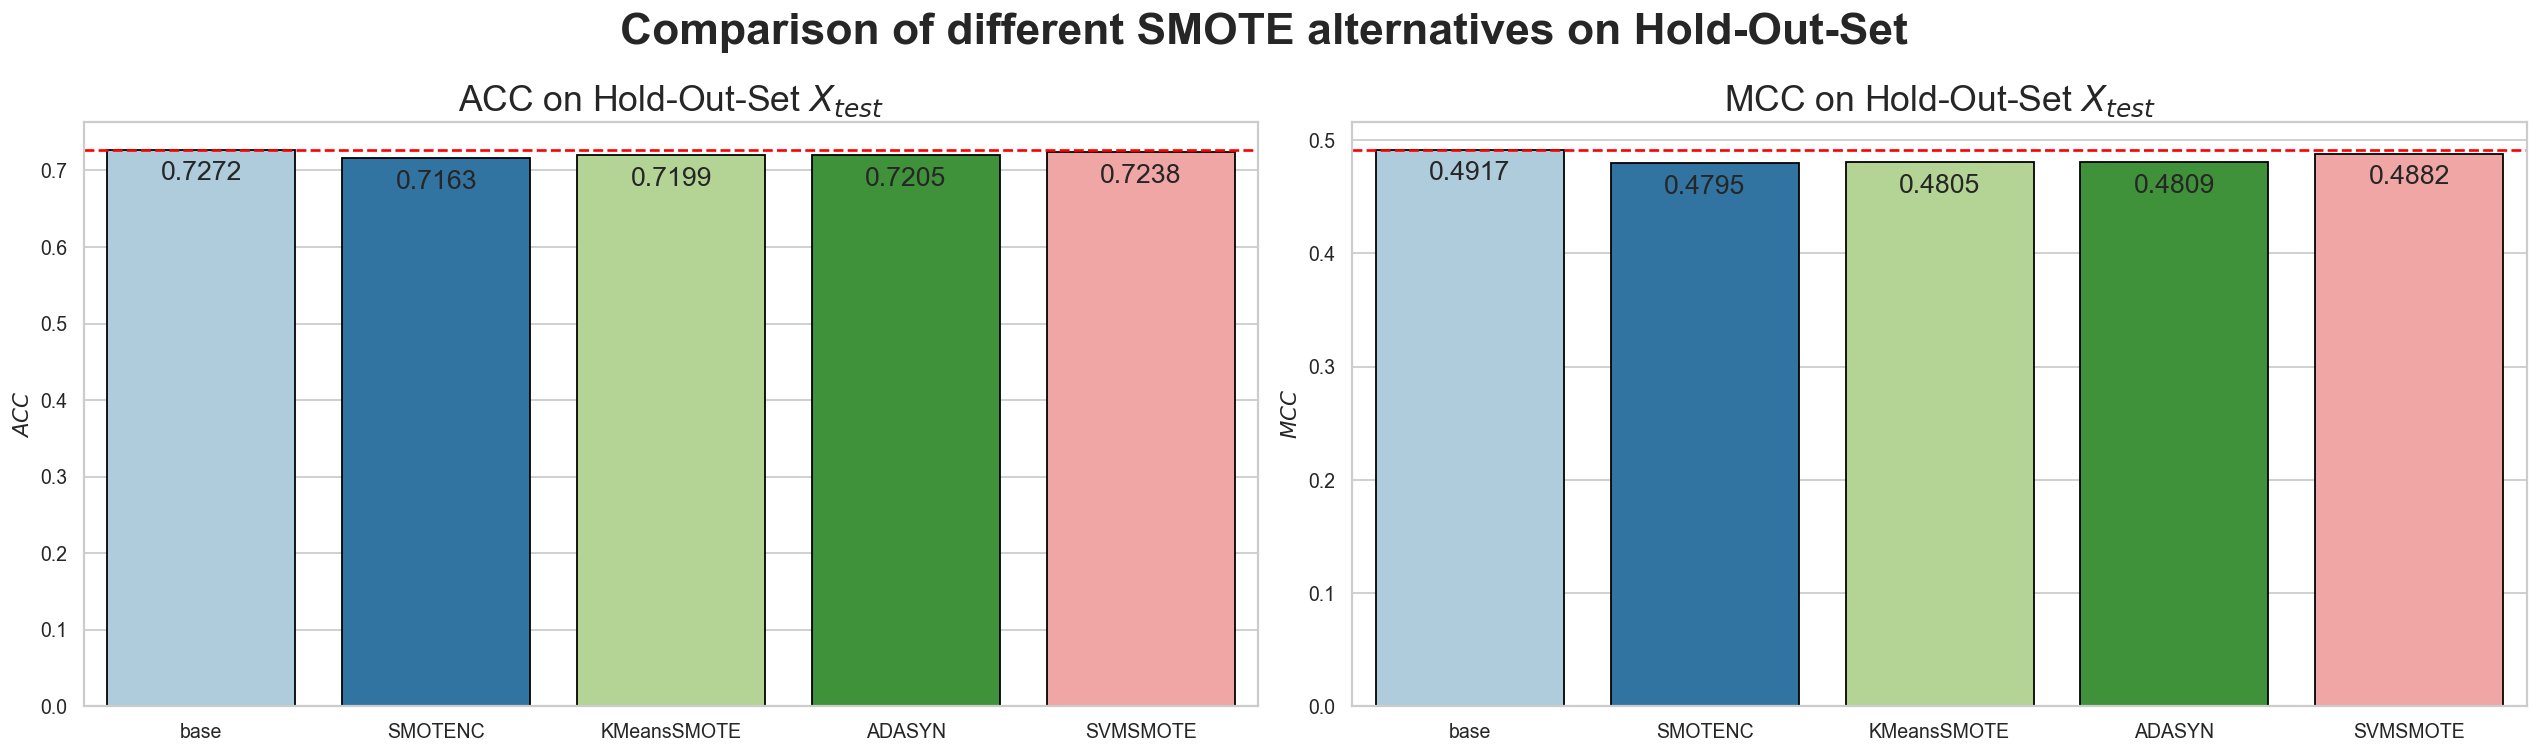

Saved figure in results/test_results_rus_of_2023-05-18 15:45:50.341011.png


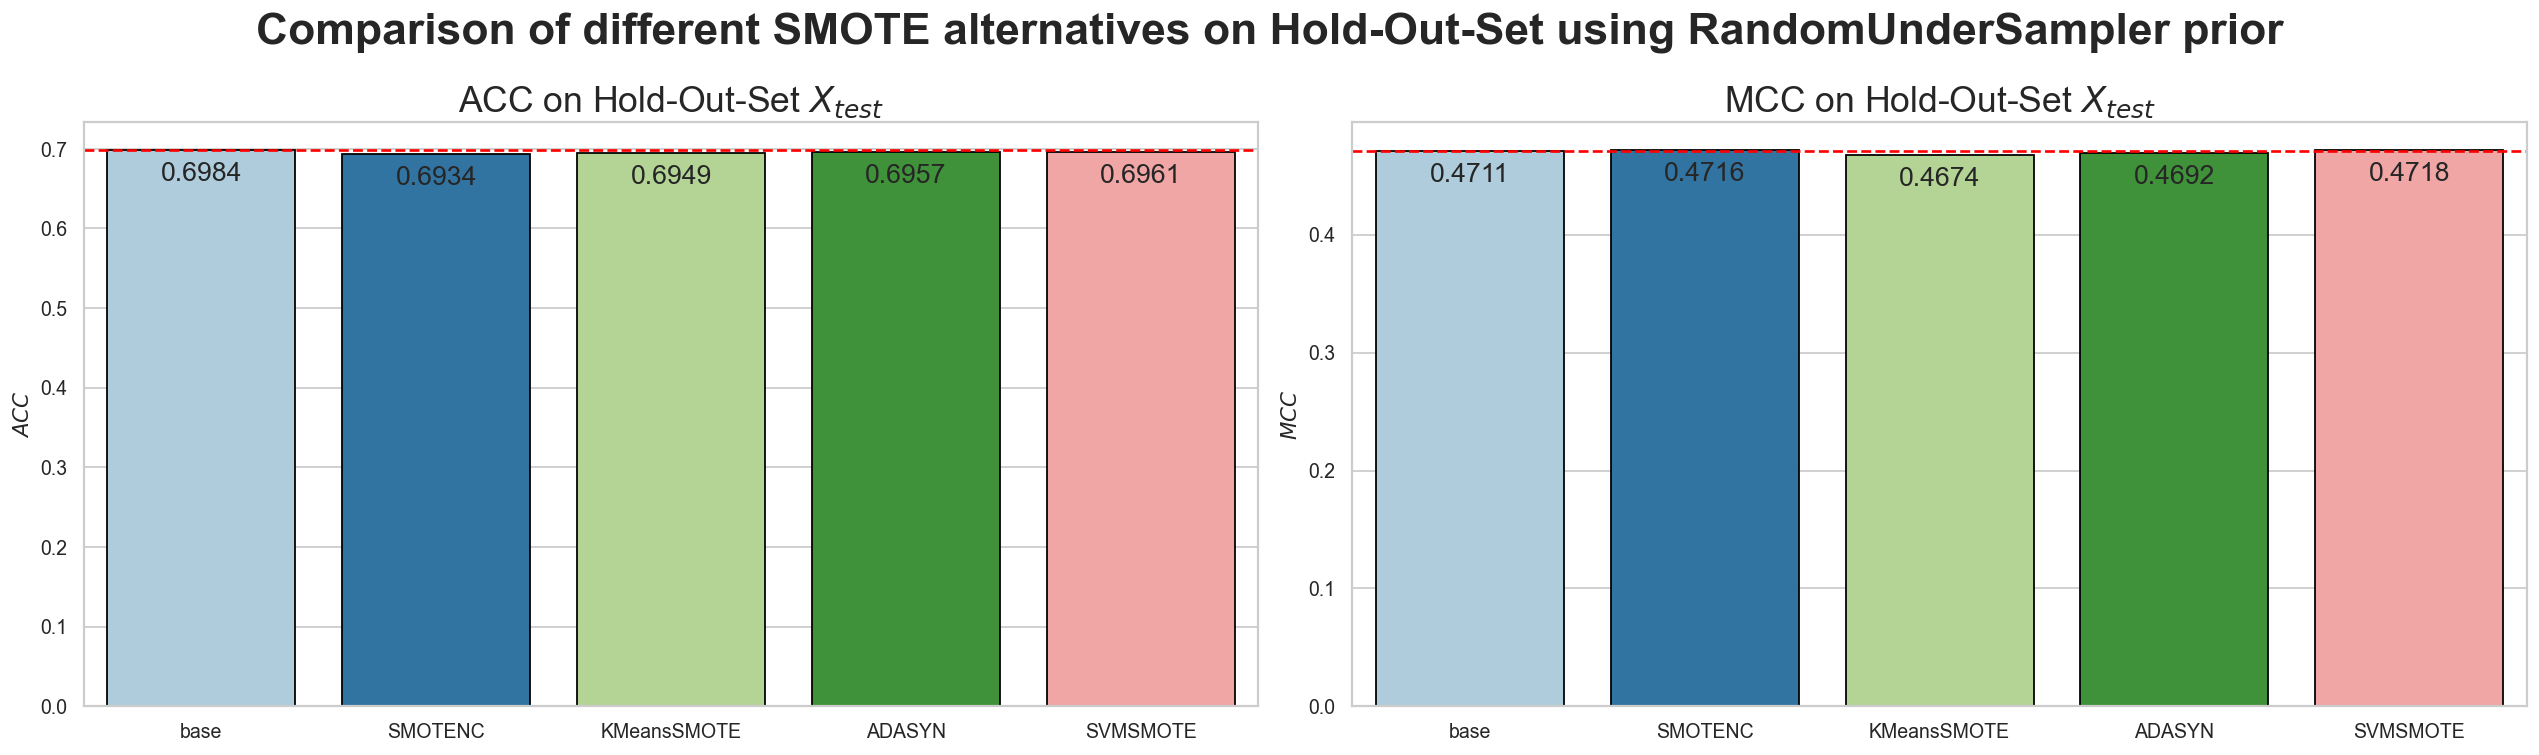

In [89]:
def plot_test_results(df = results_test_set, rus = False, savefig=False, figname="test_res"):
    """
    Function to plot test results.
    :param df: DataFrame of test results; yielded from fit_data_using_sampler method
    :param rus: bool whether results with RUS were used
    :param savefig: bool whether to save fig
    :param figname: Name of figure to save
    :return: None
    """
    rus_string = ""
    if rus:
        rus_string = "using RandomUnderSampler prior"

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6), dpi=128)
    fig.suptitle(f"Comparison of different SMOTE alternatives on Hold-Out-Set {rus_string}", size=25, fontweight="bold")
    g = sns.barplot(x=df.columns.to_list(), y=df.loc["ACC", :].to_list(), ax = axes[0], edgecolor="black")
    g.bar_label(g.containers[0], fmt="%.4f", padding=-20, size=15)
    axes[0].set_title("ACC on Hold-Out-Set $X_{test}$", size=20)
    axes[0].set_ylabel("$ACC$")
    axes[0].axhline(y=df.loc["ACC", "base"], color="red", linestyle="--")
    h = sns.barplot(x=df.columns.to_list(), y=df.loc["MCC", :].to_list(), ax = axes[1], edgecolor="black")
    h.bar_label(h.containers[0], fmt="%.4f", padding=-20, size=15)
    axes[1].set_title("MCC on Hold-Out-Set $X_{test}$", size=20)
    axes[1].set_ylabel("$MCC$")
    axes[1].axhline(y=df.loc["MCC", "base"], color="red", linestyle="--")
    plt.tight_layout()
    if savefig:
        path = f"results/{figname}_of_{datetime.datetime.now()}.svg"
        plt.savefig(path, dpi=256)
        print(f"Saved figure in {path}")
    plt.show()


plot_test_results(results_test_set, savefig=True, figname="test_results")
plot_test_results(results_test_set_rus, rus=True, savefig=True, figname="test_results_rus")